# Assignment 2 - Q03

Conditional GAN  Architecture
- Implements the generator based on the original Conditional GAN paper, capable of generating realistic faces from sketch inputs.  
- Integrates the sketch input into the model, enabling accurate conditioning during both training and inference.
- Evaluation and Analysis
- Produces visually realistic and accurate face images based on input sketches, demonstrating the generator's ability to map sketches to faces.


## Reading Images

In [ ]:
sketch_folder_path = ".\\Q4test\\sketches"
image = cv2.imread(sketch_folder_path)
photo_folder_path = ".\\Q4test\\photos"


# Preprocessing

In [ ]:
# Define image transformations (normalization, resizing, etc.)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 (or whatever your model needs)
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image between -1 and 1
])


### <span style = "color : magenta">Checking Shape of Image</span>

In [ ]:
import cv2 
image = cv2.imread(".\\Q4test\\photos\\class1\\4.jpg")
#"C:\Users\Zunaira\Documents\7th Semester\Gen AI\Assignments\A02\\Q4test\\photos\\class1\\4.jpg"
print("The shape of the image is",image.shape)

# <span style = "color : magenta">Defining GAN</span>

## <span style = "color : orange"> Generator </span>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Generator model (U-Net Style)
def build_generator():
    inputs = layers.Input(shape=(512, 512, 1))  # Sketch input shape (512x512, 1 channel)
    
    # Downsampling layers (Encoder)
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(inputs)
    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(down1)
    down3 = layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')(down2)
    
    # Bottleneck
    bottleneck = layers.Conv2D(512, (4, 4), strides=2, padding='same', activation='relu')(down3)
    
    # Upsampling layers (Decoder)
    up1 = layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same', activation='relu')(bottleneck)
    up2 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', activation='relu')(up1)
    up3 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', activation='relu')(up2)
    
    # Final output layer (1 channel for grayscale output)
    output = layers.Conv2DTranspose(1, (4, 4), strides=2, padding='same', activation='tanh')(up3)
    
    model = tf.keras.models.Model(inputs, output)
    return model


## <span style = "color : orange"> Discriminator </span>

In [ ]:

# Discriminator model
def build_discriminator():
    input_sketch = layers.Input(shape=(512, 512, 1))  # Sketch input
    input_image = layers.Input(shape=(512, 512, 1))   # Real or generated image input
    
    # Concatenate the sketch and the image
    concatenated = layers.Concatenate()([input_sketch, input_image])
    
    # Discriminator layers
    d = layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(concatenated)
    d = layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(d)
    d = layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')(d)
    d = layers.Flatten()(d)
    d = layers.Dense(1, activation='sigmoid')(d)
    
    model = tf.keras.models.Model([input_sketch, input_image], d)
    return model


## <span style = "color : orange"> Building CGAN </span>

In [4]:
import os
from PIL import Image
import numpy as np

# Paths to your directories
sketches_dir = r'C:\\Users\\Zunaira\\Documents\\7th Semester\\Gen AI\\Assignments\\A02\\test\\sketches'
photos_dir = r'C:\\Users\\Zunaira\\Documents\\7th Semester\\Gen AI\\Assignments\\A02\\test\\photos'

# Function to load and preprocess images
def load_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize((512, 512))  # Resize to 512x512
    image = np.array(image) / 127.5 - 1  # Normalize to [-1, 1]
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return image

def load_data(batch_size=1):
    # Get random filenames from both directories
    sketch_filenames = os.listdir(sketches_dir)
    photo_filenames = os.listdir(photos_dir)
    
    # Load images in batches
    sketches_batch = []
    photos_batch = []
    
    for _ in range(batch_size):
        sketch_file = np.random.choice(sketch_filenames)
        photo_file = np.random.choice(photo_filenames)
        
        # Load and preprocess images
        sketch = load_image(os.path.join(sketches_dir, sketch_file))
        photo = load_image(os.path.join(photos_dir, photo_file))
        
        sketches_batch.append(sketch)
        photos_batch.append(photo)
    
    # Convert lists to numpy arrays
    sketches_batch = np.array(sketches_batch)
    photos_batch = np.array(photos_batch)
    
    return photos_batch, sketches_batch


## <span style = "color : orange"> Compiling Generator and Discriminator </span>

In [ ]:
# Hyperparameters
BATCH_SIZE = 1
EPOCHS = 1000
learning_rate = 0.0002

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

# Loss function (Binary Crossentropy)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Build models
generator = build_generator()
discriminator = build_discriminator()

## <span style = "color : orange"> Training </span>

In [ ]:

# Training loop
@tf.function
def train_step(real_images, sketches):
    # Create labels for real (1) and fake (0)
    real_labels = tf.ones((BATCH_SIZE, 1))
    fake_labels = tf.zeros((BATCH_SIZE, 1))
    
    # Train the discriminator
    with tf.GradientTape() as tape:
        generated_images = generator(sketches, training=True)
        real_output = discriminator([sketches, real_images], training=True)
        fake_output = discriminator([sketches, generated_images], training=True)
        
        real_loss = loss_fn(real_labels, real_output)
        fake_loss = loss_fn(fake_labels, fake_output)
        discriminator_loss = real_loss + fake_loss
    
    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train the generator
    with tf.GradientTape() as tape:
        generated_images = generator(sketches, training=True)
        fake_output = discriminator([sketches, generated_images], training=True)
        
        generator_loss = loss_fn(real_labels, fake_output)
    
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    return discriminator_loss, generator_loss


C:\Users\Zunaira\AppData\Roaming\Python\Python310\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 0/1000 - Discriminator Loss: 1.4096, Generator Loss: 0.2022


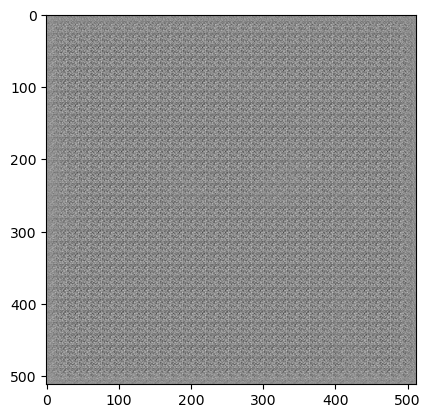

Epoch 100/1000 - Discriminator Loss: 0.0054, Generator Loss: 27.1726


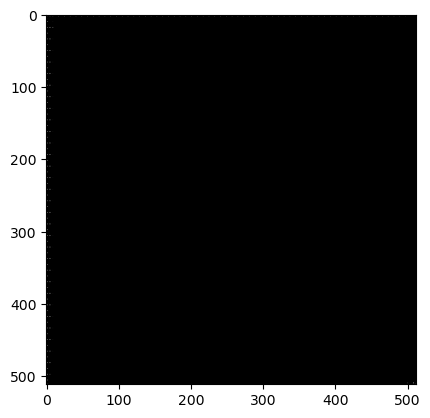

Epoch 200/1000 - Discriminator Loss: 0.0000, Generator Loss: 14.7131


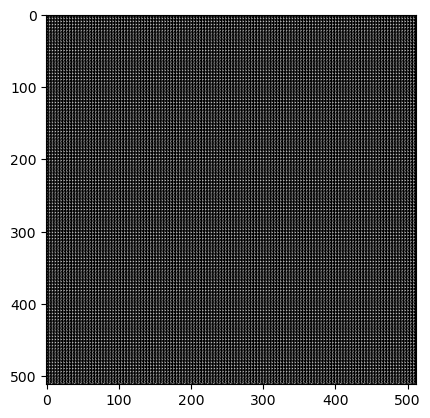

Epoch 300/1000 - Discriminator Loss: 0.0000, Generator Loss: 25.6348


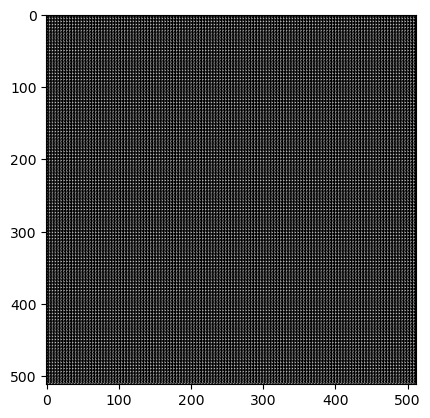

Epoch 400/1000 - Discriminator Loss: 0.0000, Generator Loss: 24.7333


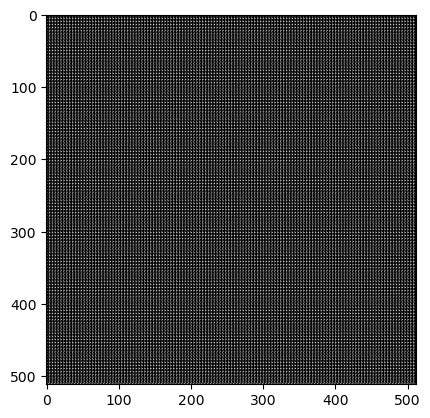

Epoch 500/1000 - Discriminator Loss: 0.0000, Generator Loss: 25.0965


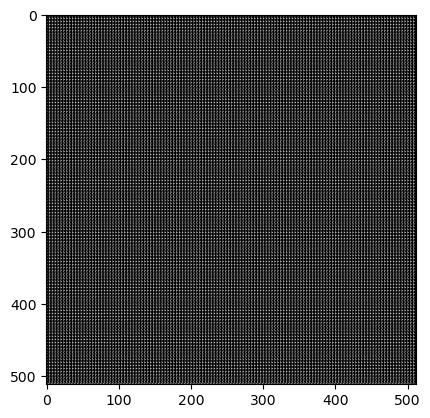

Epoch 600/1000 - Discriminator Loss: 0.0000, Generator Loss: 12.6653


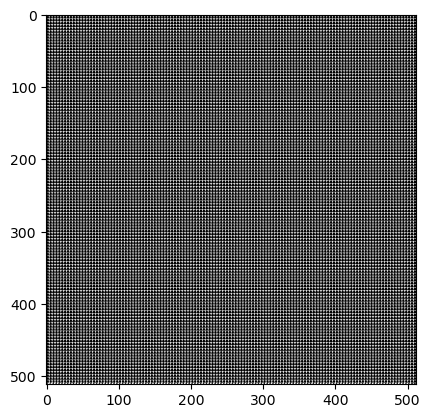

Epoch 700/1000 - Discriminator Loss: 0.0000, Generator Loss: 28.4421


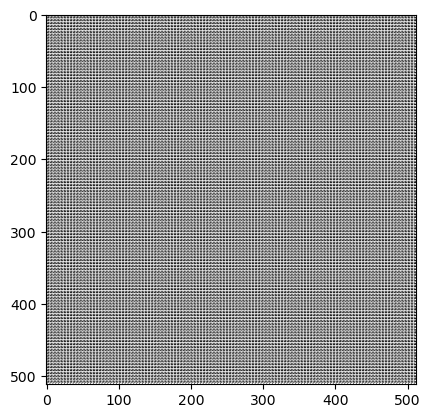

Epoch 800/1000 - Discriminator Loss: 0.0000, Generator Loss: 40.1200


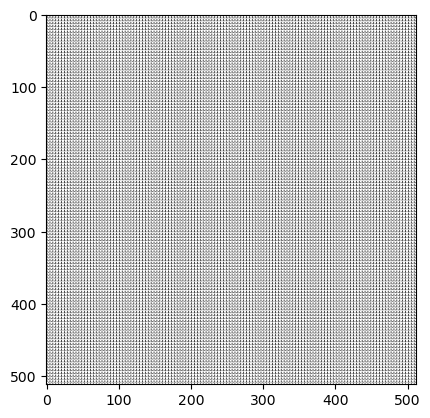

Epoch 900/1000 - Discriminator Loss: 0.0000, Generator Loss: 41.5967


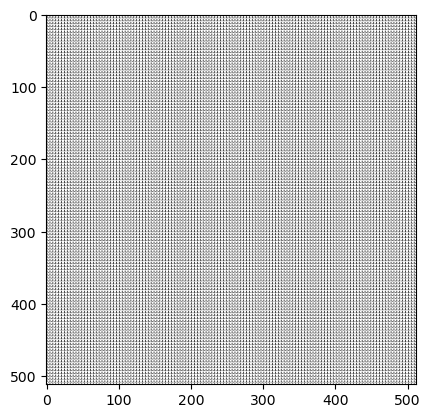

In [ ]:

# Training function
def train(epochs):
    for epoch in range(epochs):
        real_images, sketches = load_data()
        d_loss, g_loss = train_step(real_images, sketches)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} - Discriminator Loss: {d_loss:.4f}, Generator Loss: {g_loss:.4f}")
            # Optionally save the generated images
            generated_image = generator(sketches, training=False)[0]
            plt.imshow(generated_image.numpy().squeeze(), cmap='gray')
            plt.show()

# Start training
train(EPOCHS)


## Save Model

In [6]:
import os

# Directory to save your models
save_dir = r'C:\\Users\\Zunaira\\Documents\\7th Semester\\Gen AI\\Assignments\\A02\\saved_models'
os.makedirs(save_dir, exist_ok=True)

# Save the generator and discriminator models
def save_models(epoch, generator, discriminator):
    generator.save(os.path.join(save_dir, f'generator_epoch_{epoch}.h5'))
    discriminator.save(os.path.join(save_dir, f'discriminator_epoch_{epoch}.h5'))
    print(f'Models saved at epoch {epoch}')

# Modify the training function to save the models periodically
def train(epochs):
    for epoch in range(epochs):
        real_images, sketches = load_data()
        d_loss, g_loss = train_step(real_images, sketches)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} - Discriminator Loss: {d_loss:.4f}, Generator Loss: {g_loss:.4f}")
            # Save models every 100 epochs
            save_models(epoch, generator, discriminator)


## Load Saved Models

In [7]:
# Load the generator and discriminator models
from tensorflow.keras.models import load_model

generator = load_model(os.path.join(save_dir, 'generator_epoch_100.h5'))
discriminator = load_model(os.path.join(save_dir, 'discriminator_epoch_100.h5'))


# <span style = "color : cyan"> ** BEYONCEE **</span>